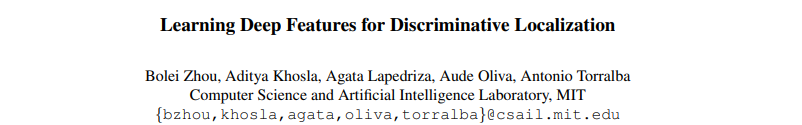

# Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

# Download and prepare the dataset


In [2]:
# Cats vs Dogs Dataset
tfds.disable_progress_bar()
 
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
 
# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
 
(train_examples, validation_examples, test_examples) = splits
 
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
 
BATCH_SIZE = 32
 
def normalize_and_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (224, 224))
 
    return image, label
 
# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(normalize_and_resize).batch(1)

Dataset cats_vs_dogs downloaded and prepared to C:\Users\ebdl\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


train/valid/test dataset을 준비합니다

# Modeling and Train

In [3]:
def build_model():
    base_model = tf.keras.applications.VGG16(input_shape= (224, 224, 3),
                                             weights='imagenet',  # 사전 훈련된 가중치
                                             include_top=False)  # FC layer는 포함하지 않겠다. 특징 추출기만 가져온다.
    
    # basemodel의 출력을 입력으로 받아 GAP 레이어 추가
    output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)  
 
    # output 레이어에 2개의 뉴런을 가진 Dense 레이어 추가. 개, 고양이에 대한 확률을 나타냄
    output = tf.keras.layers.Dense(2, activation='softmax')(output)
 
    # 모델 (input,output) 생성
    model = tf.keras.Model(base_model.input, output)
 
    for layer in base_model.layers[:-4]:  # 마지막 4개 레이어를 제외한 모든 레이어를 동결시킴
        layer.trainable = False           # 사전 훈련된 가중치를 고정시켜 업데이트되지 않도록함
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    model.summary()
 
    return model
    
model = build_model()

58892288/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

top의 classifier을 제외한 VGG16 모델을 불러오고, classifier는 GAP와 Dense layer로 구성

10 Epochs 학습을 진행

In [4]:
EPOCHS = 10
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 67s 102ms/step - loss: 1.5708 - acc: 0.8051 - val_loss: 0.1503 - val_acc: 0.9402
Epoch 2/10
582/582 [==============================] - 59s 100ms/step - loss: 0.1930 - acc: 0.9373 - val_loss: 0.1390 - val_acc: 0.9433
Epoch 3/10
582/582 [==============================] - 59s 100ms/step - loss: 0.1269 - acc: 0.9535 - val_loss: 0.1366 - val_acc: 0.9523
Epoch 4/10
582/582 [==============================] - 59s 100ms/step - loss: 0.1165 - acc: 0.9645 - val_loss: 0.1186 - val_acc: 0.9518
Epoch 5/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1106 - acc: 0.9701 - val_loss: 0.1264 - val_acc: 0.9570
Epoch 6/10
582/582 [==============================] - 59s 101ms/step - loss: 0.0860 - acc: 0.9753 - val_loss: 0.1311 - val_acc: 0.9561
Epoch 7/10
582/582 [==============================] - 59s 101ms/step - loss: 0.0698 - acc: 0.9796 - val_loss: 0.2380 - val_acc: 0.9536
Epoch 8/10
582/582 [==============================] - 5

# Class Activation Map(CAM) 

CAM은 마지막 conv layer와 FC layer의 weights를 사용해서 구하게 됩니다.

여기서 FC layer의 weight는 각 class에 대한 feature weight가 되며, 이 weights는 각 class의 feature vector들입니다

마지막 Conv layer의 feature map과 FC layer의 weight를 곱해서 합해서 살펴보면, 모델이 이미지의 어떤 부분을 보고 class를 분류했는지 알 수 있게 됩니다.

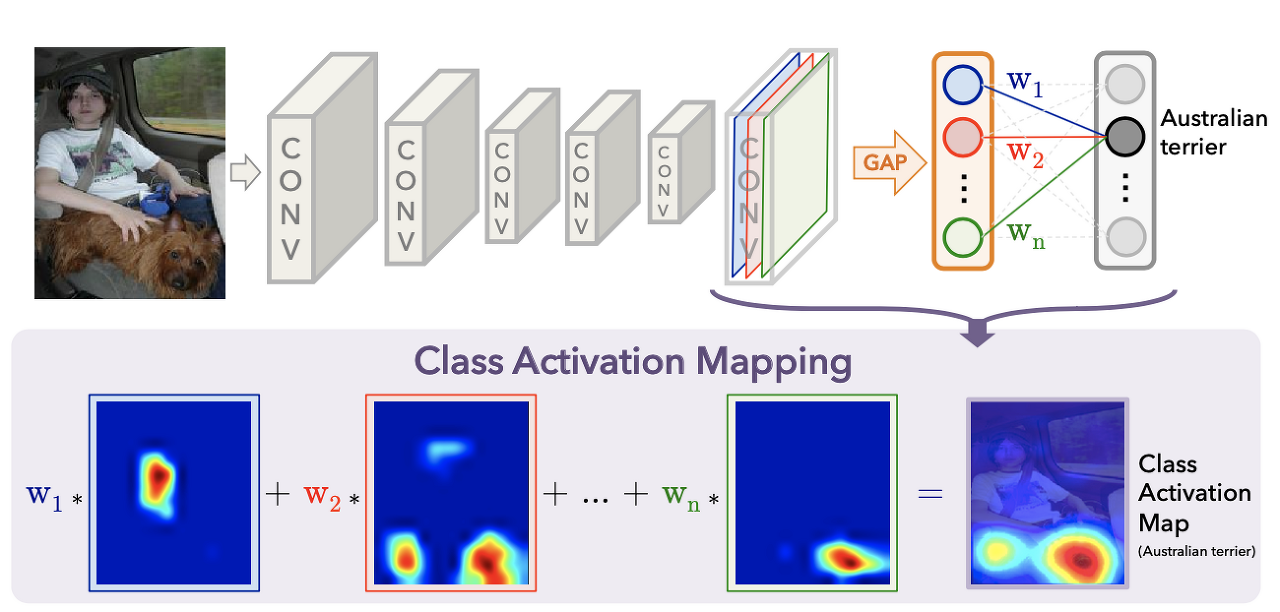

.

먼저 Dense layer의 weight와 마지막 Conv layer(block5_conv3)을 output으로 하는 cam_model을 정의하고, CAM을 이미지로 보여주는 함수를 정의한다.

In [5]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

기본 model과 동일하지만, 마지막 conv layer인 block5_conv3의 feature map도 output으로 출력하는 것이 차이임

.

사용될 GAP weight인 Dense layer의 weight 예시

In [6]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 2)

In [7]:
gap_weights

array([[-0.08224357, -0.05301949],
       [-0.01566766, -0.05217289],
       [-0.00027432, -0.0521495 ],
       ...,
       [ 0.0961578 ,  0.07791952],
       [-0.08979597, -0.01047119],
       [ 0.03543813, -0.10330625]], dtype=float32)

마지막 conv layer의 feature map의 모양이 (7, 7, 512) 이고 GAP를 통해 (512, )의 모양을 가지고, 
<br>
최종 output은 2개의 class에 대한 확률이므로, Dense layer의 weights는 (512, 2)의 모양을 갖는다. 
<br><br>
여기서 1열은 class 0(cats)의 feature vector이며, 2열은 class 1(dogs)의 feature vector임

.

CAM 시각화 함수

In [8]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 224 x 224
        features (array) -- features of the image, shape (1, 7, 7, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (224,224))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

input image와 cam_model을 통한 결과 feature map과 prediction을 파라미터로 입력받고, 원래는 마지막 gap_weights와 feature map을 내적해주고 모두 더함(element-wise). 

예측하는 label의 weight vector만을 내적하여 그래서 실제 이미지 위에 CAM을 나타내고, 해당 클래스를 높은 확률로 예측할 때 어디를 주로 보는지 확인

In [22]:
# preprocess the test images
augmented_test_data = test_examples.map(normalize_and_resize)
test_batches = augmented_test_data.batch(1)

In [23]:
augmented_test_data

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [24]:
test_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

test를 통해 확인

ground truth: cat
sigmoid output: [[1. 0.]]
prediction: cat


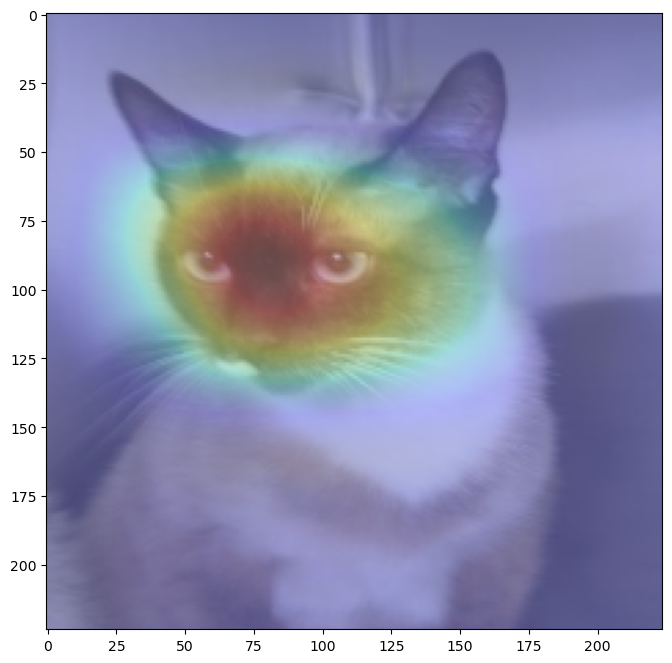

ground truth: dog
sigmoid output: [[3.4017969e-12 1.0000000e+00]]
prediction: dog


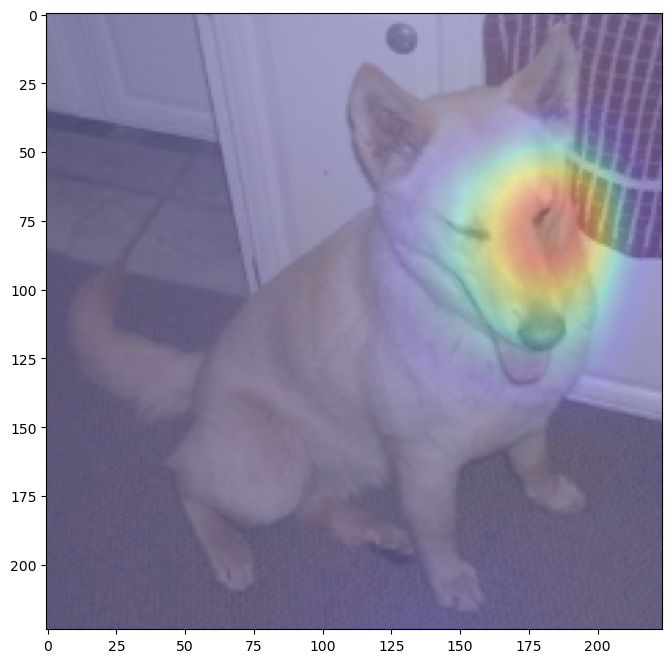

ground truth: dog
sigmoid output: [[1.8396024e-17 1.0000000e+00]]
prediction: dog


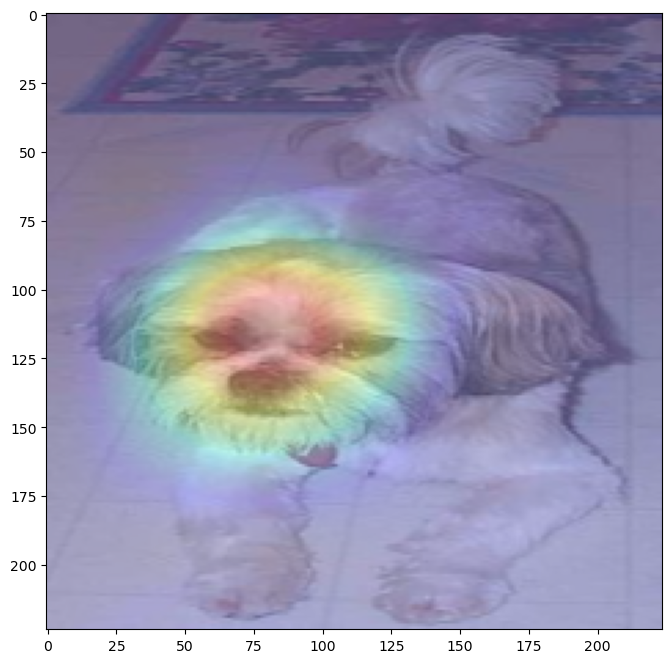

In [25]:
for img, lbl in test_batches.take(3):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features,results = cam_model.predict(img)
    show_cam(img, features, results, lbl)

feature map과 weights의 0열 vector가 곱해진 결과

**다음과 같이 강아지와 고양이를 분류할 때는 주로 얼굴을 보고 구분하는 것을 볼 수 있다!**